###  draw_particle

In [7]:
import numpy as np

params = {'p_num': 10, 'aff_sig': [0.1, 0.1, 0.4, 0.3]}

aff_params = [30, 50, 10, 20]

In [8]:
aff_params_M = np.kron(np.ones((params['p_num'],1)), np.array(aff_params))

# First onstruct a 4*p_num size normal distribution with 
# mean 0 and sigma 1
rand_norml_M = np.array([np.random.standard_normal(4) for _ in range(params['p_num'])])

# Then construct a affine sigma matrix
aff_sig_M = np.kron(np.ones((params['p_num'], 1)), params['aff_sig'])

# Update particles 
aff_params_M += rand_norml_M * aff_sig_M

In [9]:
aff_params_M[0]

array([ 30.05841706,  49.97663013,   9.76552821,  19.99608601])

In [14]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

show = skimage.io.imshow
%matplotlib inline


import matplotlib.pyplot as plt
import scipy.stats as st
import os
import sys
import numpy as np 

# Import custom class and functions
from inputproducer import InputProducer
from tracker import TrackerVanilla
from vgg16 import Vgg16
from selcnn import SelCNN
from utils import img_with_bbox, IOU_eval


In [43]:
## Define varies path
DATA_ROOT = 'data/Dog1'
IMG_PATH = os.path.join(DATA_ROOT, 'img')
GT_PATH = os.path.join(DATA_ROOT, 'groundtruth_rect.txt')

inputProducer = InputProducer(IMG_PATH, GT_PATH)
img, gt, t  = next(inputProducer.gen_img)
roi, roi_pos, preimg, pad = inputProducer.extract_roi(img, gt)

/home/xlws/repos/FCNT_TF/inputproducer.py:107: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


In [111]:
def extract_roi_old(img, gt, roi_size):
	"""Extract ROI from img with target centered.

	Returns:
	    roi: tensor,
	    roi_pos: list of params for roi_pos, [tlx, tly, h, w]

	"""
	assert max(gt[2:]) <= roi_size

	# Construct an padded img first.
	convas = np.zeros([img.shape[0]+2*roi_size, img.shape[1]+2*roi_size, 3])
	convas[roi_size:-roi_size, roi_size:-roi_size] = img

	# Compute target center location in convas
	tlx_convas, tly_convas = gt[0]+roi_size, gt[1]+roi_size
	cx = tlx_convas + int(0.5 * gt[2])
	cy = tly_convas + int(0.5 * gt[3])

	# Crop an roi_size region centered at cx, cy
	scale_sz = max(gt[2:]) * 2.5
	half = scale_sz // 2
	roi = convas[cy-half:cy+half, cx-half:cx+half, :]

	# compute new target pos in roi window
	new_cx, new_cy = [int(i*0.5) for i in roi.shape[:-1]]
	new_x = new_cx - gt[2] // 2
	new_y = new_cx - gt[3] // 2
    
	roi_resized = imresize(roi, (roi_size, roi_size))
	resize_factor = roi_size / roi.shape[0]
	return roi_resized, [new_x, new_y, gt[2], gt[3]], resize_factor

In [112]:
roi_o, gt_o, resize_factor = extract_roi_old(img, gt, roi_size)

/home/xlws/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


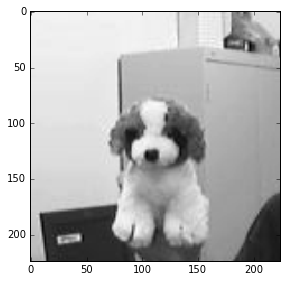

In [113]:
show(roi_o.astype(np.uint8))

In [117]:
resize_factor 

1.7777777777777777

In [29]:

from scipy.misc import imresize


In [63]:

# resie pre_M to roi_size 
roi_size = roi.shape[0]
pre_M = roi[100:-100, 100:-100,0] # eg
pre_M_resized = imresize(pre_M, [roi_size, roi_size], interp='bicubic')

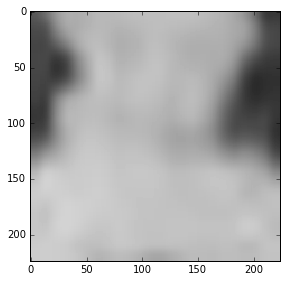

In [64]:
show(pre_M_resized)

In [67]:
# gen particle
params= {'aff_sig': [0.4, 0.4, 0.8, 0.7], 'p_num': 20}
dof = len(params['aff_sig'])

# Construct an p_num*6 size matrix with with each 
# column repersents one particle

#aff_params_M = np.kron(np.ones((self.params['p_num'],1)), np.array(aff_params))

# First onstruct a p_num*dof size normal distribution with 
# mean 0 and sigma 1
rand_norml_M = np.array([np.random.standard_normal(dof) for _ in range(params['p_num'])])

# Then construct a affine sigma matrix
aff_sig_M = np.kron(np.ones((params['p_num'], 1)), params['aff_sig'])

# Update particles 
aff_params_M = rand_norml_M * aff_sig_M

In [152]:
# transform aff_params_M to location_M with each column 
# repersent [cx, cy, w, h] in the pre_M heat map
loc_M = np.zeros(aff_params_M.shape)
tlx, tly, w, h = gt

cx, cy = roi_size // 2, roi_size // 2

loc_M[:, 0] = cx
loc_M[:, 1] = cy
loc_M[:, 2] = resize_factor * w 
loc_M[:, 3] = resize_factor * h

loc_M += aff_params_M



In [154]:
loc_M[:, 3].min()

62.866274436319465

In [163]:
loc_M = loc_M.astype(np.int)

In [155]:
x,y,w,h = loc_M[0]

In [166]:
# draw on roi
roi_t = np.copy(roi)
roi_t[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)] = 0

roi_t[~roi_t[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)]] = 22

IndexError: index 255 is out of bounds for axis 0 with size 224

In [169]:
mask = np.ma.make_mask(roi, copy=True)

In [170]:
mask

array([[[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ..., 
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ..., 
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ..., 
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       ..., 
       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ..., 
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        ..., 
        [ True,  True,  True],
        [ True,  True,  True],
        [ 

In [ ]:
mask = numpy.ma.make_mask_none(a.shape)
mask[sel_id] = True
answer = numpy.ma.masked_array(a, mask).compressed()

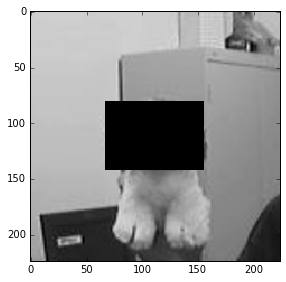

In [157]:
show(roi_t)

In [161]:
np.sum(roi[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)])

2016696

In [182]:
total = np.sum(roi)
def _compute_conf(roi, loc_p):
    cx,cy,w,h = loc_p
    conf = np.sum(roi[y-int(0.5*h): y+int(0.5*h), x-int(0.5*w):x+int(0.5*w)])
    return conf

In [183]:
_compute_conf(roi, loc_M[6], total)

0.18449200928011361

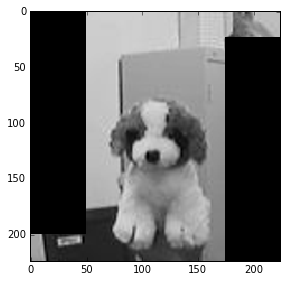

In [181]:
roi[:200, 0:50] = 0
roi[-200:, -50:] = 0

show(roi)

In [187]:
i = 0
for p in loc_M:
    i += 1
    print(p)
    break
i

[111 112  89  62]


1

In [186]:
len(loc_M)

20

In [227]:
a = [99,8,9,22,2]
b =  [1,1,3,4,2]


[99, 8, 9, 22, 2, 1, 1, 3, 4, 2]

In [192]:
import queue

In [193]:
q = queue.Queue(maxsize= 20)

In [226]:
q.put((19,9,3), block=)

KeyboardInterrupt: 

In [209]:
records = []
for _ in range(21):
    if q.

(12, 9, 3)

/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


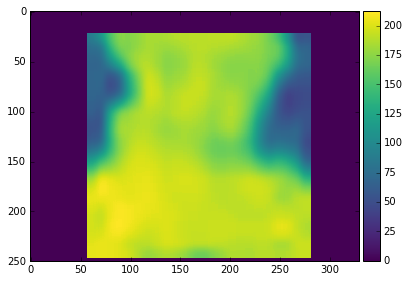

In [60]:
# place pre_M_resized on a padded img size convas
pad = 10
assert pad % 2 == 0
convas_shape = [i+10 for i in img.shape[:2]]
convas = np.zeros(shape=convas_shape)

tlx, tly, w, h = gt
p_tlx = tlx + int(0.5*pad)
p_tly = tly + int(0.5*pad)

cx = p_tlx + int(0.5*w)
cy = p_tly + int(0.5*h)
half_roi = int(0.5 * roi_size)
convas[cy-half_roi:cy+half_roi, cx-half_roi:cx+half_roi] = pre_M_resized
show(convas)

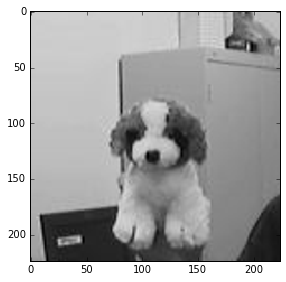

In [61]:
show(roi)

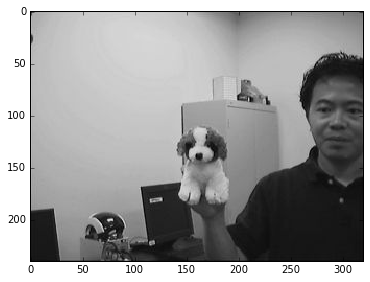

In [62]:
show(img)

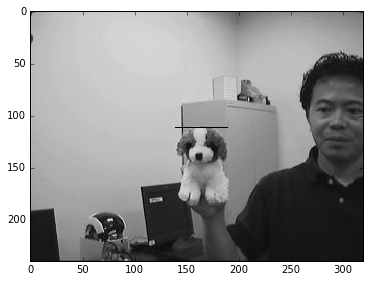

In [47]:
img1 = np.copy(img)
tlx, tly, w, h = gt
img1[tly, tlx:tlx+w, :] = 0

show(img1)

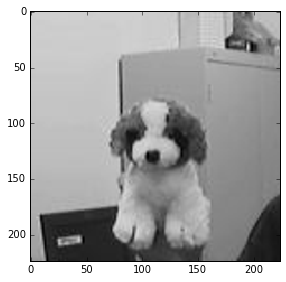

In [32]:
# place 